## Lab | Making predictions with logistic regression


In [123]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#categorical Variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


In [2]:
password = getpass.getpass()

In this lab, you will be using the Sakila database of movie rentals.
In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

In [3]:
# connection string
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

##### 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [82]:
query1 = '''
SELECT f.title, f.rental_duration, f.rental_rate, f.length, f.rating, r.rental_date, r.return_date, fc.category_id
FROM film f 
JOIN inventory i USING(film_id)
JOIN rental r USING(inventory_id)
JOIN film_category fc USING (film_id)
WHERE date_format((r.rental_date), "%%Y")=2005 
ORDER BY film_id ASC;
'''


film_description, film_id: no because for every film different
release_year, language_id: no, because the same for all values in the table
special_features: no, because quite a lot of infos.

In [83]:
data = pd.read_sql(query1, engine)
data.head()

,title,rental_duration,rental_rate,length,rating,rental_date,return_date,category_id
0,ACADEMY DINOSAUR,6,0.99,86,PG,2005-07-08 19:03:15,2005-07-11 21:29:15,6
1,ACADEMY DINOSAUR,6,0.99,86,PG,2005-08-02 20:13:10,2005-08-11 21:35:10,6
2,ACADEMY DINOSAUR,6,0.99,86,PG,2005-08-21 21:27:43,2005-08-30 22:26:43,6
3,ACADEMY DINOSAUR,6,0.99,86,PG,2005-05-30 20:21:07,2005-06-06 00:36:07,6
4,ACADEMY DINOSAUR,6,0.99,86,PG,2005-06-17 20:24:00,2005-06-23 17:45:00,6


#### 2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

#### 3. Read the data into a Pandas dataframe.

In [146]:
#This query is wrong --> it gives me the whole table with a new boolean column. what we want is only the list of distinct films with a boolean. After this 
#I will need to create a new volumn with

query2 = '''SELECT film_id, 
CASE WHEN date_format((r.rental_date), "%%M-%%Y") = "May-2005" THEN True ELSE False END AS rented_in_may_2005
FROM film f 
JOIN inventory i USING(film_id)
JOIN rental r USING(inventory_id)
JOIN film_category fc USING (film_id)
ORDER BY film_id ASC;'''

In [147]:
data2 = pd.read_sql(query2, engine)
data2.head()

,film_id,rented_in_may_2005
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [103]:
data['rented_in_may_2005'] = data2['rented_in_may_2005']
data.head()

,title,rental_duration,rental_rate,length,rating,rental_date,return_date,category_id,rented_in_may_2005
0,ACADEMY DINOSAUR,6,0.99,86,PG,2005-07-08 19:03:15,2005-07-11 21:29:15,6,0
1,ACADEMY DINOSAUR,6,0.99,86,PG,2005-08-02 20:13:10,2005-08-11 21:35:10,6,0
2,ACADEMY DINOSAUR,6,0.99,86,PG,2005-08-21 21:27:43,2005-08-30 22:26:43,6,0
3,ACADEMY DINOSAUR,6,0.99,86,PG,2005-05-30 20:21:07,2005-06-06 00:36:07,6,1
4,ACADEMY DINOSAUR,6,0.99,86,PG,2005-06-17 20:24:00,2005-06-23 17:45:00,6,0


#### 4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [104]:
data.dtypes

title                         object
rental_duration               object
rental_rate                   object
length                         int64
rating                        object
rental_date           datetime64[ns]
return_date           datetime64[ns]
category_id                   object
rented_in_may_2005             int64
dtype: object

In [105]:
#remove the rows with NaN-Values
data = data[~data['return_date'].isna()]
data.isna().sum()

title                 0
rental_duration       0
rental_rate           0
length                0
rating                0
rental_date           0
return_date           0
category_id           0
rented_in_may_2005    0
dtype: int64

In [106]:
# These will be treated as categorical
data['rental_duration'] = data['rental_duration'].astype('object')
data['rental_rate'].value_counts()
data['rental_rate'] = data['rental_rate'].astype('object') 
data['category_id'] = data['category_id'].astype('object')
data['rented_in_may_2005'] = data['rented_in_may_2005'].astype('bool')


<AxesSubplot:>

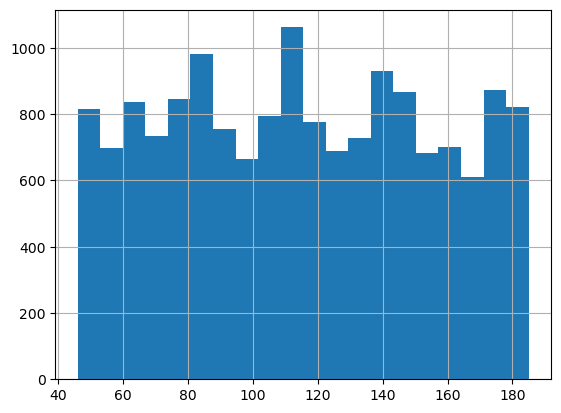

In [116]:
# This will be changed into a categorical variable as well by binning:
data['length'].value_counts()

%matplotlib inline
data['length'].hist(bins=20)



In [119]:

# cut in 5 equally spaced bins
labels = ["Very Short", "Short", "Medium", "Long", "Very Long"]
data['length'] = pd.cut(data['length'],5, labels=labels)
data['length'].value_counts()

Medium        3320
Short         3248
Long          3207
Very Short    3082
Very Long     3004
Name: length, dtype: int64

In [120]:
data['length']

0             Short
1             Short
2             Short
3             Short
4             Short
            ...    
15857    Very Short
15858    Very Short
15859    Very Short
15860    Very Short
15861    Very Short
Name: length, Length: 15861, dtype: category
Categories (5, object): ['Very Short' < 'Short' < 'Medium' < 'Long' < 'Very Long']

##### X-y-split and train-test-split

In [121]:
# then train transformation on training set only
y = data['rented_in_may_2005']
X = data.drop('rented_in_may_2005', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

We will not do a numerical transformation since, we have only categorical variables!

In [122]:
X_train_categorical = X_train.select_dtypes(include = object)

In [131]:
encoder = OneHotEncoder(drop='first').fit(X_train_categorical)
#print(encoder.categories_)
encoded_train = encoder.transform(X_train_categorical).toarray()

cols = encoder.get_feature_names(input_features=X_train_categorical.columns)
cols

X_train_cat = pd.DataFrame(encoded_train, columns=cols)
X_train_cat.head()

X_train_transformed = X_train_cat
#X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

/Users/josephinebonvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [130]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',  # In this case we get a warning for our solver..--> change solver or more iterations, we have the default state of iterations in this case.
                  multi_class='multinomial').fit(X_train_transformed, y_train)


In [132]:
X_test_categorical = X_test.select_dtypes(include = object)
encoded_test = encoder.transform(X_test_categorical).toarray()

X_test_cat = pd.DataFrame(encoded_test, columns=cols)
X_test_cat.head()

,title_ACE GOLDFINGER,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALABAMA DEVIL,title_ALADDIN CALENDAR,title_ALAMO VIDEOTAPE,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
list(X_train_cat.columns)==list(X_test_cat.columns)

X_test_transformed = X_test_cat
#X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [135]:
# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
predictions

array([False, False, False, ..., False, False, False])

In [136]:
classification.score(X_test_transformed, y_test)

0.9284588717302238

In [137]:
print(y_test.value_counts())

False    2946
True      227
Name: rented_in_may_2005, dtype: int64


In [138]:
pd.Series(predictions).value_counts()

False    3173
dtype: int64

In [139]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[2946,    0],
       [ 227,    0]])

In [ ]:
# predicted         | False | True  |
# --------------------------
# actual  False     |   +   |       |
# --------------------------
#         True      |       |   +   |


We can see that there is a very high imbalance